#*EEG-DCViT*







In [1]:
#@title Install dependencies
!pip install numpy
!pip install pandas
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117
!pip install scikit-learn
!pip install transformers
!pip install tqdm
!pip install matplotlib

Looking in indexes: https://download.pytorch.org/whl/cu117
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 GB 733.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.3/132.3 kB 21.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 44.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 90.6 MB/s eta 0:00:00
  Created wheel for lit: filename=lit-15.0.7-py3-none-any.whl size=89987 sha256=c75528ad0a42ffc500c3f1496a6de0df1d62d1f389198224e1254f0b36ecb218
  Stored in directory: /root/.cache/pip/wheels/27/2c/b6/3ed2983b

In [2]:
#@title Install libraries

from enum import Enum
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import transformers
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.cluster import KMeans
from transformers import ViTFeatureExtractor, ViTForImageClassification, ViTModel
from tqdm import tqdm
from matplotlib import pyplot as plt
from math import floor, sqrt
import matplotlib.pyplot as pyplot


##How to Run
Select dataset from dropdown below and go to Runtime>Run all

Don't run with less than 50% data. Training step won't work.

In [3]:
#@title Select Parameters

class RunType(Enum):
    NORMAL = 1
    CLUSTER = 2
    CLASSIFIER = 3

class Environment(Enum):
  COLAB = 1
  AZURE = 2


run_type  = RunType.CLUSTER #@param [ 'RunType.NORMAL', 'RunType.CLUSTER' , 'RunType.CLASSIFIER'] {type: "raw"}

dataset_name = 'Position_task_with_dots_synchronised_min'  # @param [ 'Position_task_with_dots_synchronised_min','Position_task_with_dots_synchronised_max',  'Position_task_with_dots_synchronised_min_hilbert', 'LR_task_with_antisaccade_synchronised_min', 'test' ] {type:"string"}


percent_of_data = 1.00 # @param {type:"slider", min:0.0, max:1.0, step:0.02}

#default =0

use_augmentation = False  # @param {type:"boolean"}

# @markdown ---
#default 15
n_epoch = 15 # @param [15,30,60]{type:"raw"}
#default .0001
learning_rate = 0.0001 # @param [1e-2, 1e-3, 1e-4, 1e-5] {type:"raw"}
#default = 64
batch_size = 64 # @param [8,16,32,64,96, 128] {type:"raw"}
#default = 6
step_size = 6 # @param [6,8,10,20] {type:"raw"}
#default = .1
dropout = 0.1 # @param [0.0, 0.1, 0.2, 0.3, 0.4, 0.5] {type:"raw"}

l2_regularization = 0  # @param [0, 0.1, 0.01, 0.001] {type:"raw"}


# @markdown ---

environment = Environment.COLAB #@param ['Environment.COLAB', 'Environment.AZURE'] {type:"raw"}


save_model_as = 'EEG-LiT-best.pt'# @param {type:"string"}

# @markdown ---
kernel1, kernel2 = [(1,36), (8,1)]
data_shape = [500, 129]
plot_threshold= 55.4

conv1_bias = False

num_clusters = 25




## Download Dataset
Store dataset in Google Drive for persistent storage

In [4]:
# download data
if environment == Environment.COLAB:
  !pip install torch
  from google.colab import drive
  drive.mount('/content/drive')


file_dir = '/content/drive/MyDrive/EEGViT_DATA/'

if not os.path.exists(f'{file_dir}{dataset_name}.npz'):
  !mkdir {file_dir}

  !wget -P {file_dir} https://files.osf.io/v1/resources/ktv7m/providers/dropbox/prepared/{dataset_name}.npz




Mounted at /content/drive


In [5]:
# Set seed for reproducibility
SEED = 2
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

#Define Model Code Base

In [6]:
class EEGEyeNetDataset(Dataset):
    def __init__(self, data_file, transpose = True, transform=None):

        print('loading data...')
        with np.load(data_file) as f: # Load the data array
            num_elements = int(len(f['EEG']) * percent_of_data)
            self.trainX = f['EEG'][:num_elements]
            self.trainY = pd.DataFrame(f['labels'][:num_elements])
            self.trainY = self.trainY.drop(0, axis=1)

        print(self.trainY)
        if transpose:
            self.trainX = np.transpose(self.trainX, (0,2,1))[:,np.newaxis,:,:]

        self.transform=transform

    def __getitem__(self, index):
        # Read a single sample of data from the data array
        X = torch.from_numpy(self.trainX[index]).float()
        y = torch.from_numpy(self.trainY.loc[index][0:2].values).float()
        # Return the tensor data
        if self.transform:
          X = self.transform(X)

        return (X,y,index)

    def __len__(self):
        # Compute the number of samples in the data array
        return len(self.trainX)

class EEGViT_classifier(nn.Module):
    def __init__(self, dropout = 0.1, conv1_bias = False, channels1=64, channels2=768,m2=768, model_name="google/vit-base-patch16-224", kernel1=(1,35), kernel2=(8,1)):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=channels1,
            kernel_size=kernel1,
            stride=kernel1,
            padding=(0,0),
            bias=conv1_bias
        )

        self.batchnorm1 = nn.BatchNorm2d(channels1, eps=1e-12)
        # self.batchnorm1 = nn.BatchNorm2d(256, False)
        img_size = (round(500/kernel1[1]), round(129/kernel2[0]))

        config = transformers.ViTConfig.from_pretrained(model_name)
        config.update({'num_channels': channels1})
        config.update({'image_size': (129, img_size[0] )})
        config.update({'patch_size': (kernel2) })

        model = transformers.ViTForImageClassification.from_pretrained(model_name, config=config, ignore_mismatched_sizes=True)
        model.vit.embeddings.patch_embeddings.projection = torch.nn.Conv2d(channels1, channels2, kernel_size=kernel2, stride=kernel2, padding=(0,0), groups=channels1)
        model.classifier=torch.nn.Sequential(torch.nn.Linear(m2,1000,bias=True),
                                     torch.nn.Dropout(p=dropout),
                                     torch.nn.Linear(1000,num_clusters,bias=True))

        self.ViT = model

    def forward(self,x):
        x = self.conv1(x)
        # print("After conv1:", x.shape)
        x = self.batchnorm1(x)
        # print("After batchnorm1:", x.shape)
        x = self.ViT.forward(x).logits
        # print("After ViT:", x.shape)
        return x



class EEGViT_pretrained(nn.Module):
    def __init__(self):
        super().__init__()
        # First Convolution Layer
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=256,
            kernel_size=(1, 36),
            stride=(1, 36),
            padding=(0, 2),
            bias=False
        )

        # Depthwise Separable Convolution Layer
        self.depthwise_conv = nn.Conv2d(
            in_channels=256,
            out_channels=256,
            kernel_size=(3, 3),
            padding=1,
            groups=256
        )
        self.pointwise_conv = nn.Conv2d(
            in_channels=256,
            out_channels=512,
            kernel_size=1
        )

        # Batch Normalization
        self.batchnorm1 = nn.BatchNorm2d(256, False)
        self.batchnorm2 = nn.BatchNorm2d(512, False)

        # Vision Transformer Configuration
        model_name = "google/vit-base-patch16-224"
        config = transformers.ViTConfig.from_pretrained(model_name)
        config.update({'num_channels': 512})
        config.update({'image_size': (129,14)})
        config.update({'patch_size': (8,1)})

        model = transformers.ViTForImageClassification.from_pretrained(
            model_name,
            config=config,
            ignore_mismatched_sizes=True
        )
        model.vit.embeddings.patch_embeddings.projection = nn.Conv2d(
            512,
            768,
            kernel_size=(8, 1),
            stride=(8, 1),
            padding=(0,0),
            groups=256
        )
        model.classifier = nn.Sequential(
            nn.Linear(768, 1000, bias=True),
            nn.Dropout(p=0.1),
            nn.Linear(1000, 2, bias=True)
        )
        self.ViT = model

    def forward(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.depthwise_conv(x)
        x = self.pointwise_conv(x)
        x = self.batchnorm2(x)
        x = self.ViT.forward(x).logits
        return x


## Load Base Model and Data into Memory

In [7]:
EEGEyeNet = EEGEyeNetDataset(f'{file_dir}{dataset_name}.npz')

if use_augmentation:

  EEGEyeNet_Flipped = EEGEyeNetDataset(f'{file_dir}{dataset_name}.npz', transform=transforms.functional.hflip)
  torch.save(EEGEyeNet_Flipped, f"{file_dir}{dataset_name}-flipped.pth", pickle_protocol=4)


loading data...
           1      2
0      408.1  315.1
1      640.7  519.1
2      404.2  118.8
3      123.9  467.1
4      711.7  460.0
...      ...    ...
21459  725.1  156.6
21460  521.4  202.8
21461  115.5  306.1
21462  732.0  310.3
21463  632.2  353.6

[21464 rows x 2 columns]


In [8]:
EEGEyeNet.trainX.shape

(21464, 1, 129, 500)

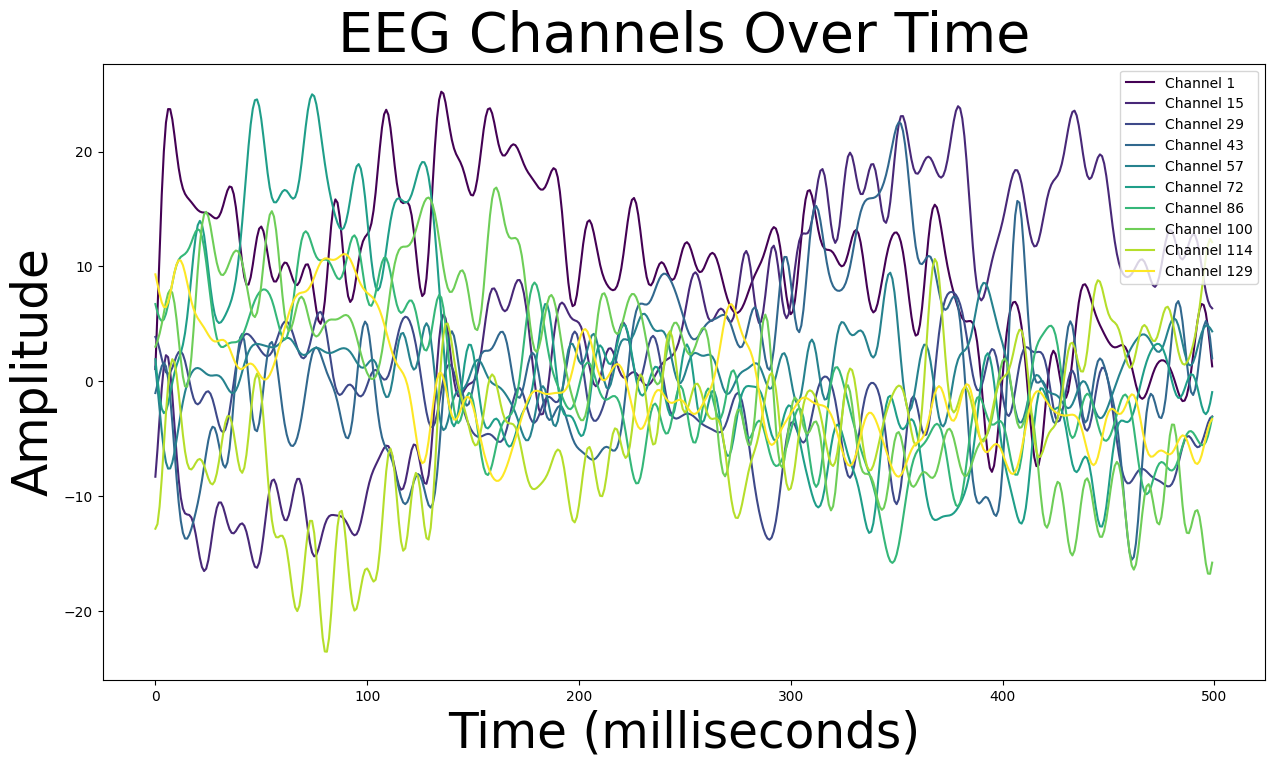

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Number of channels to plot
num_channels_to_plot = 10
channels_to_plot = np.linspace(0, 128, num_channels_to_plot, dtype=int)  # Select 10 channels evenly spaced

# Assuming each time step represents 1 millisecond for x-axis labeling
time_steps = EEGEyeNet.trainX.shape[-1]
time = np.arange(time_steps)  # Generate a time array

# Create a color map to use different colors for each channel
colors = plt.cm.viridis(np.linspace(0, 1, num_channels_to_plot))

# Select a sample to visualize
sample_index = 0  # You can change this to view different samples

plt.figure(figsize=(15, 8))

for i, channel in enumerate(channels_to_plot):
    plt.plot(time, EEGEyeNet.trainX[sample_index, 0, channel, :], label=f'Channel {channel + 1}', color=colors[i])

plt.title('EEG Channels Over Time',fontsize=40)
plt.xlabel('Time (milliseconds)',fontsize=35)
plt.ylabel('Amplitude',fontsize=35)
plt.legend(loc='upper right',fontsize=10)
plt.show()


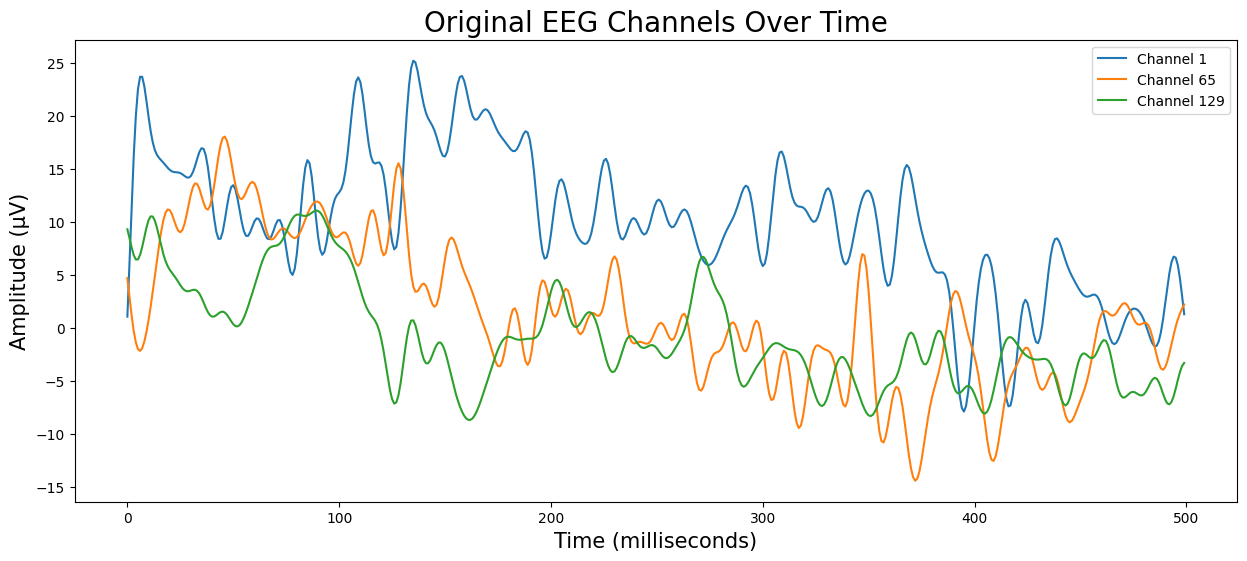

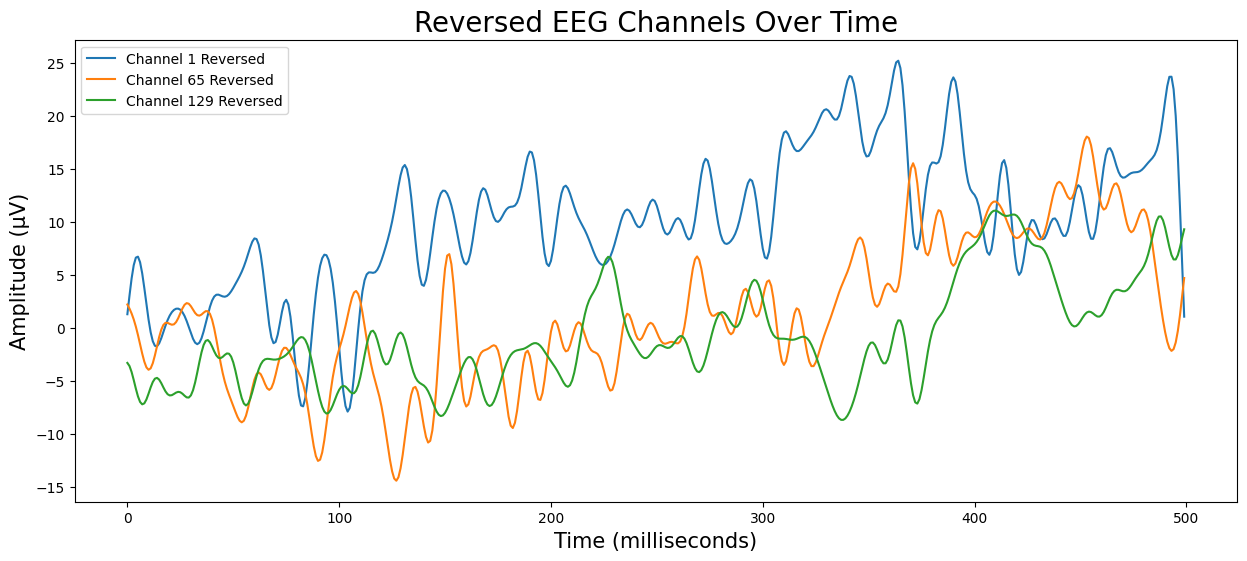

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming EEGEyeNet.trainX contains the EEG data array
# and that it is structured with the time dimension as the last dimension.

# Select three specific channels to visualize
channels_to_plot = [0, 64, 128]  # For example, choosing the first, middle, and last channel

# Select a sample to visualize
sample_index = 0  # You can change this to view different samples

# Get the time series data for the selected sample and channels
time_series_data = EEGEyeNet.trainX[sample_index, 0, channels_to_plot, :]

# Assuming each time step represents 1 millisecond
time_steps = time_series_data.shape[-1]
time = np.arange(time_steps)

# Plotting original signals
plt.figure(figsize=(15, 6))
for i, channel in enumerate(channels_to_plot):
    plt.plot(time, time_series_data[i, :], label=f'Channel {channel + 1}')

plt.title('Original EEG Channels Over Time', fontsize=20)
plt.xlabel('Time (milliseconds)', fontsize=15)
plt.ylabel('Amplitude (µV)', fontsize=15)
plt.legend()
plt.show()

# Applying time reversal transformation
# Reverse the time dimension for each channel
reversed_time_series_data = time_series_data[:, ::-1]

# Plotting reversed signals
plt.figure(figsize=(15, 6))
for i, channel in enumerate(channels_to_plot):
    plt.plot(time, reversed_time_series_data[i, :], label=f'Channel {channel + 1} Reversed')

plt.title('Reversed EEG Channels Over Time', fontsize=20)
plt.xlabel('Time (milliseconds)', fontsize=15)
plt.ylabel('Amplitude (µV)', fontsize=15)
plt.legend()
plt.show()


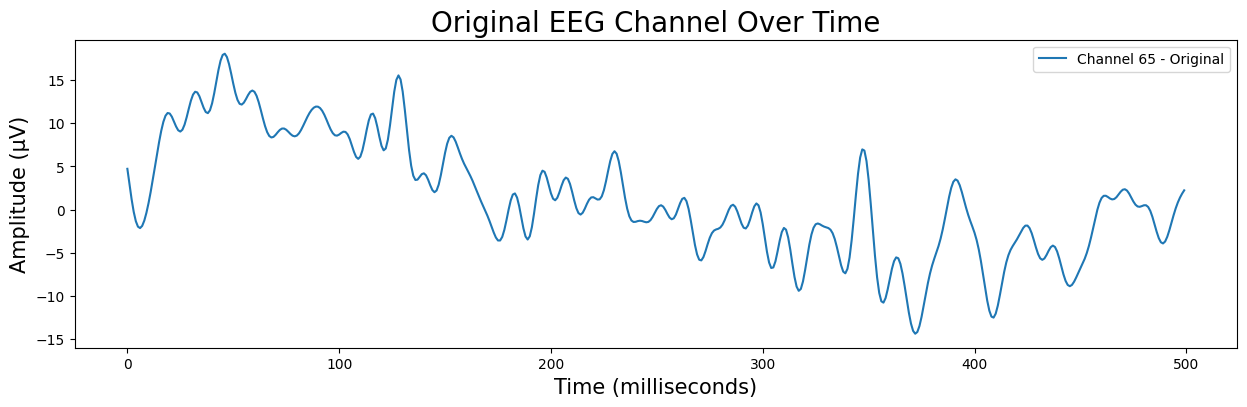

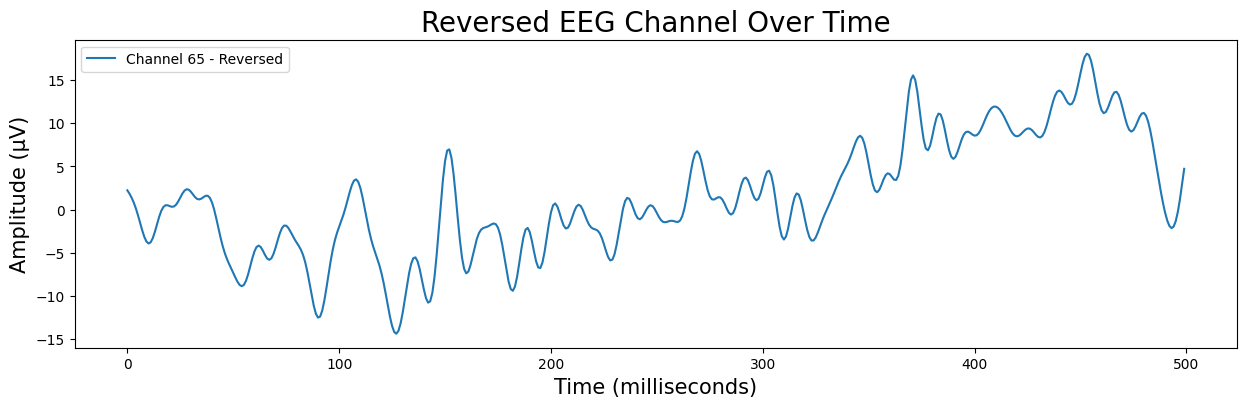

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming EEGEyeNet.trainX contains the EEG data array
# and that it is structured with the time dimension as the last dimension.

# Select one specific channel to visualize
channel_to_plot = 64  # Choosing the middle channel for demonstration

# Select a sample to visualize
sample_index = 0  # You can change this to view different samples

# Get the time series data for the selected sample and channel
time_series_data = EEGEyeNet.trainX[sample_index, 0, channel_to_plot, :]

# Assuming each time step represents 1 millisecond
time_steps = time_series_data.shape[0]
time = np.arange(time_steps)

# Plotting original signal
plt.figure(figsize=(15, 4))
plt.plot(time, time_series_data, label=f'Channel {channel_to_plot + 1} - Original')
plt.title('Original EEG Channel Over Time', fontsize=20)
plt.xlabel('Time (milliseconds)', fontsize=15)
plt.ylabel('Amplitude (µV)', fontsize=15)
plt.legend()
plt.show()

# Applying time reversal transformation
# Reverse the time dimension
reversed_time_series_data = time_series_data[::-1]

# Plotting reversed signal
plt.figure(figsize=(15, 4))
plt.plot(time, reversed_time_series_data, label=f'Channel {channel_to_plot + 1} - Reversed')
plt.title('Reversed EEG Channel Over Time', fontsize=20)
plt.xlabel('Time (milliseconds)', fontsize=15)
plt.ylabel('Amplitude (µV)', fontsize=15)
plt.legend()
plt.show()


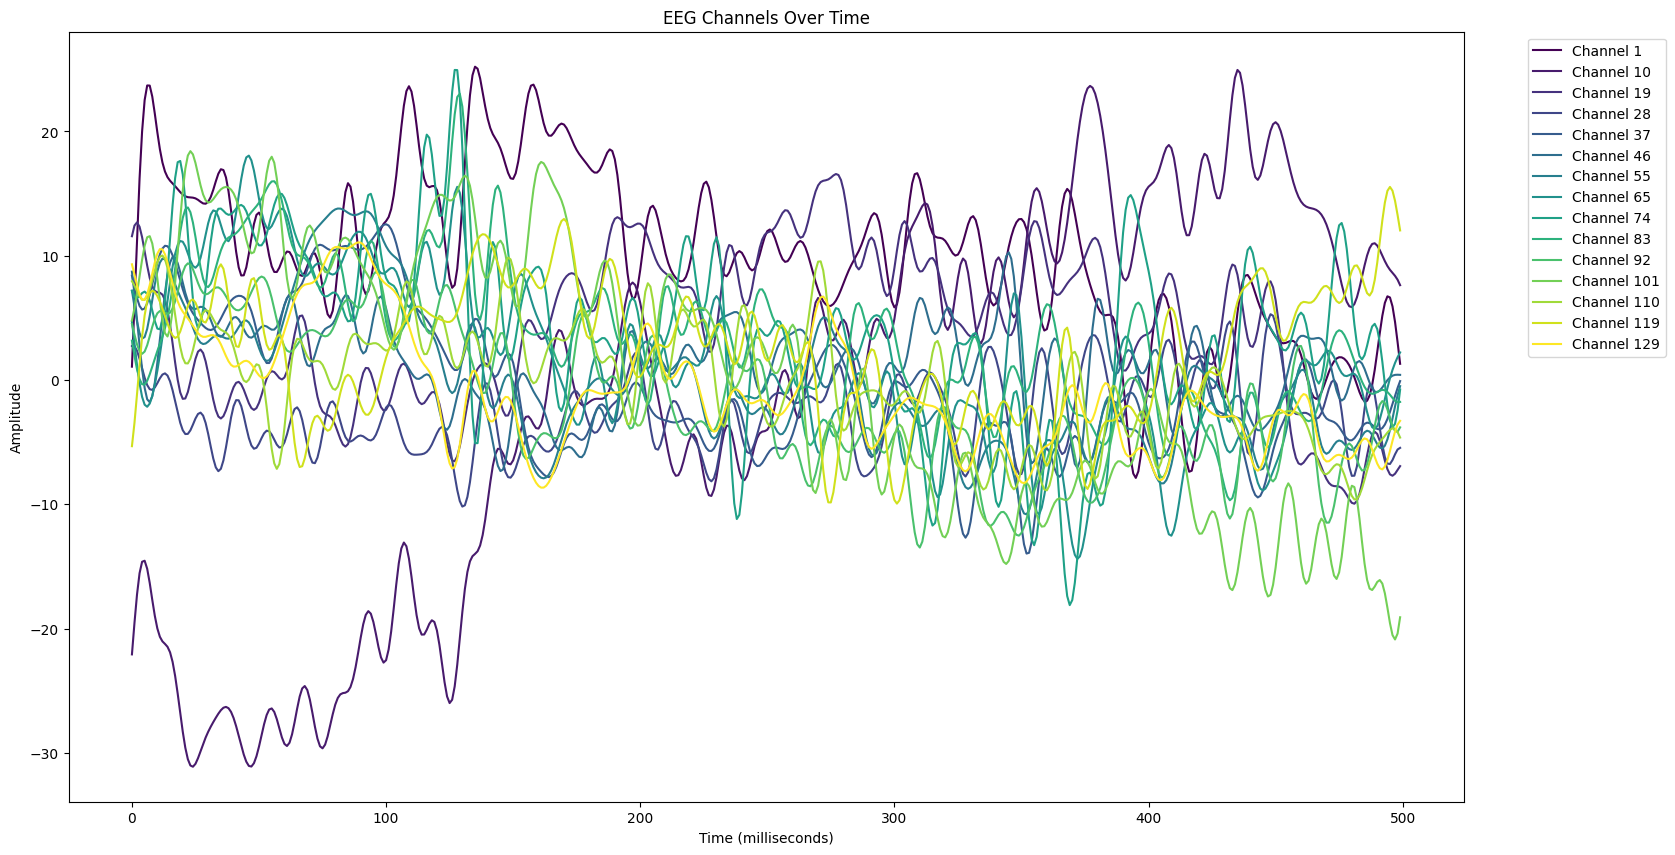

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Number of channels to plot
num_channels_to_plot = 15
channels_to_plot = np.linspace(0, 128, num_channels_to_plot, dtype=int)  # Select 15 channels evenly spaced

# Assuming each time step represents 1 millisecond for x-axis labeling
time_steps = EEGEyeNet.trainX.shape[-1]
time = np.arange(time_steps)  # Generate a time array

# Create a color map to use different colors for each channel
colors = plt.cm.viridis(np.linspace(0, 1, num_channels_to_plot))

# Select a sample to visualize
sample_index = 0  # You can change this to view different samples

plt.figure(figsize=(18, 10))  # Increased figure size for better clarity with more channels

for i, channel in enumerate(channels_to_plot):
    plt.plot(time, EEGEyeNet.trainX[sample_index, 0, channel, :], label=f'Channel {channel + 1}', color=colors[i])

plt.title('EEG Channels Over Time')
plt.xlabel('Time (milliseconds)')
plt.ylabel('Amplitude')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))  # Adjusted legend position for better visibility
plt.show()


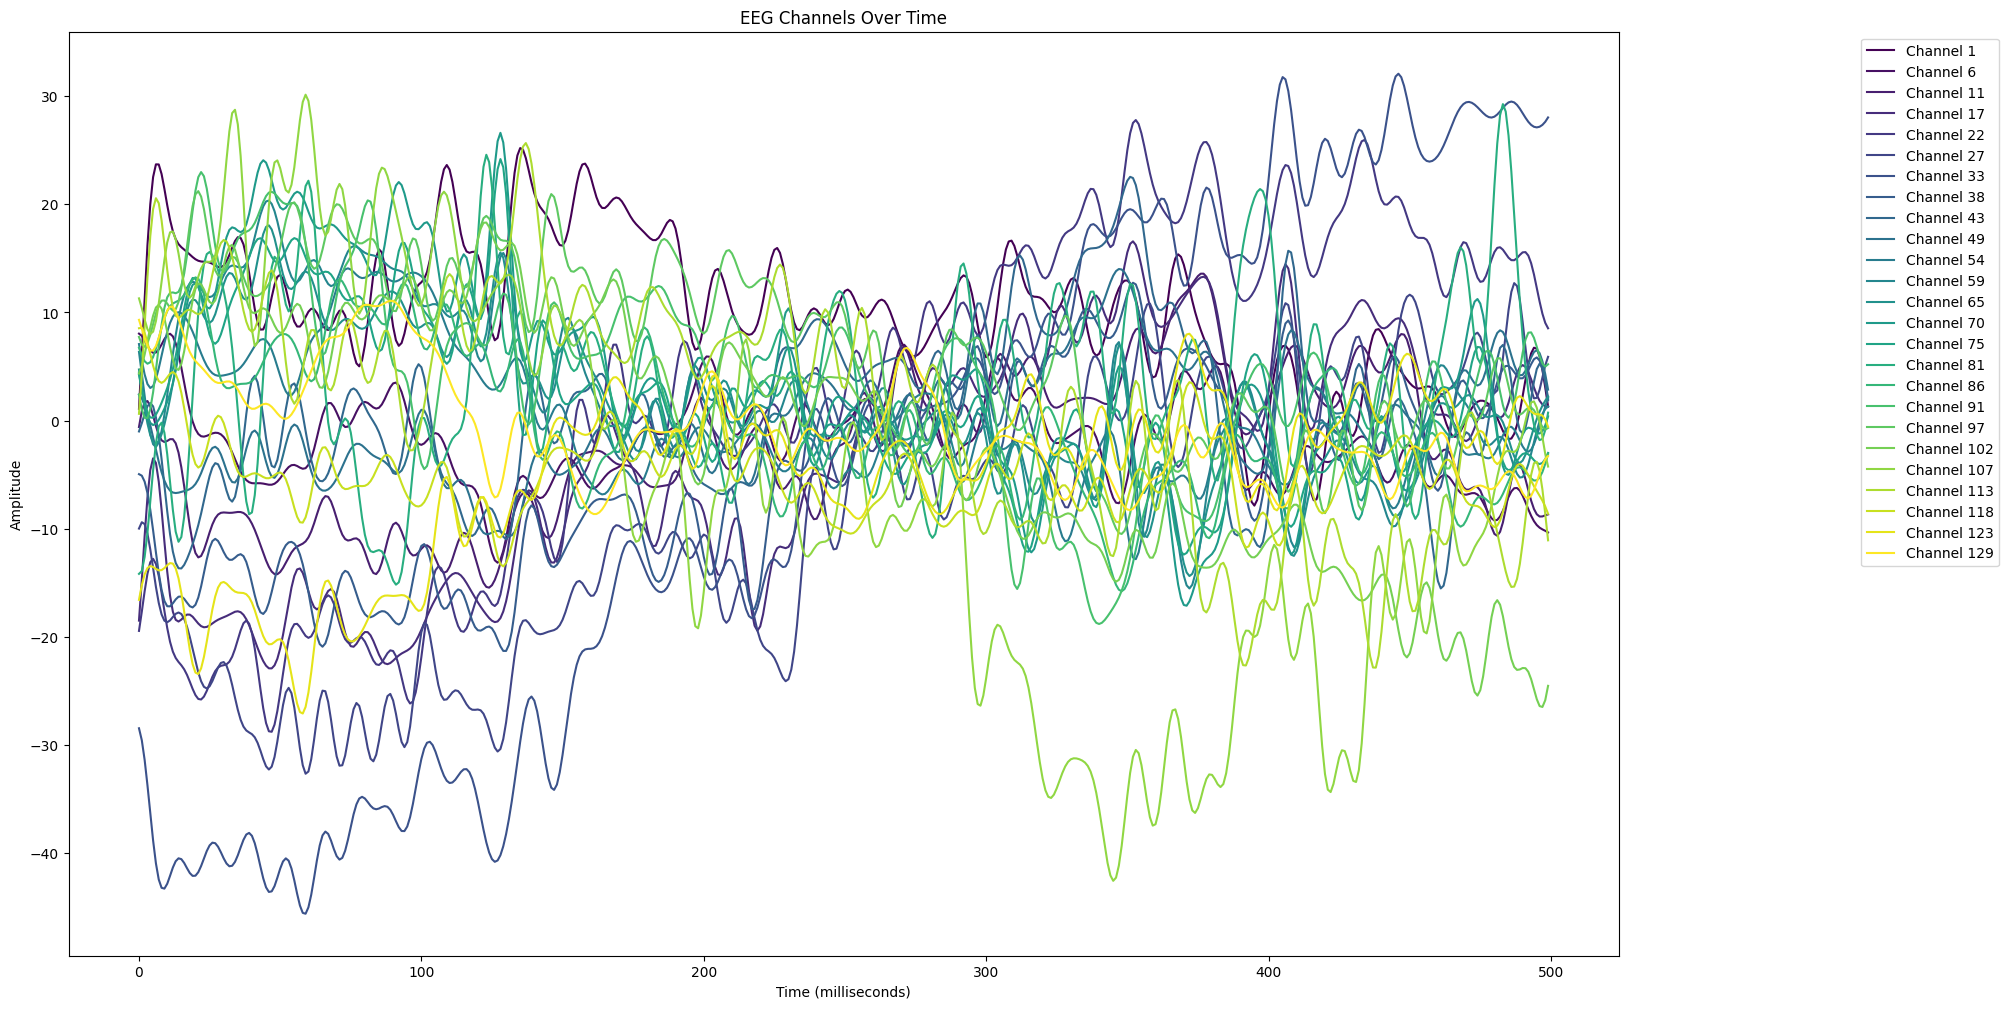

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Number of channels to plot
num_channels_to_plot = 25
channels_to_plot = np.linspace(0, 128, num_channels_to_plot, dtype=int)  # Select 25 channels evenly spaced

# Assuming each time step represents 1 millisecond for x-axis labeling
time_steps = EEGEyeNet.trainX.shape[-1]
time = np.arange(time_steps)  # Generate a time array

# Create a color map to use different colors for each channel
colors = plt.cm.viridis(np.linspace(0, 1, num_channels_to_plot))

# Select a sample to visualize
sample_index = 0  # You can change this to view different samples

plt.figure(figsize=(20, 12))  # Adjusted figure size for better clarity with more channels

for i, channel in enumerate(channels_to_plot):
    plt.plot(time, EEGEyeNet.trainX[sample_index, 0, channel, :], label=f'Channel {channel + 1}', color=colors[i])

plt.title('EEG Channels Over Time')
plt.xlabel('Time (milliseconds)')
plt.ylabel('Amplitude')
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))  # Adjusted legend position to fit all entries
plt.show()


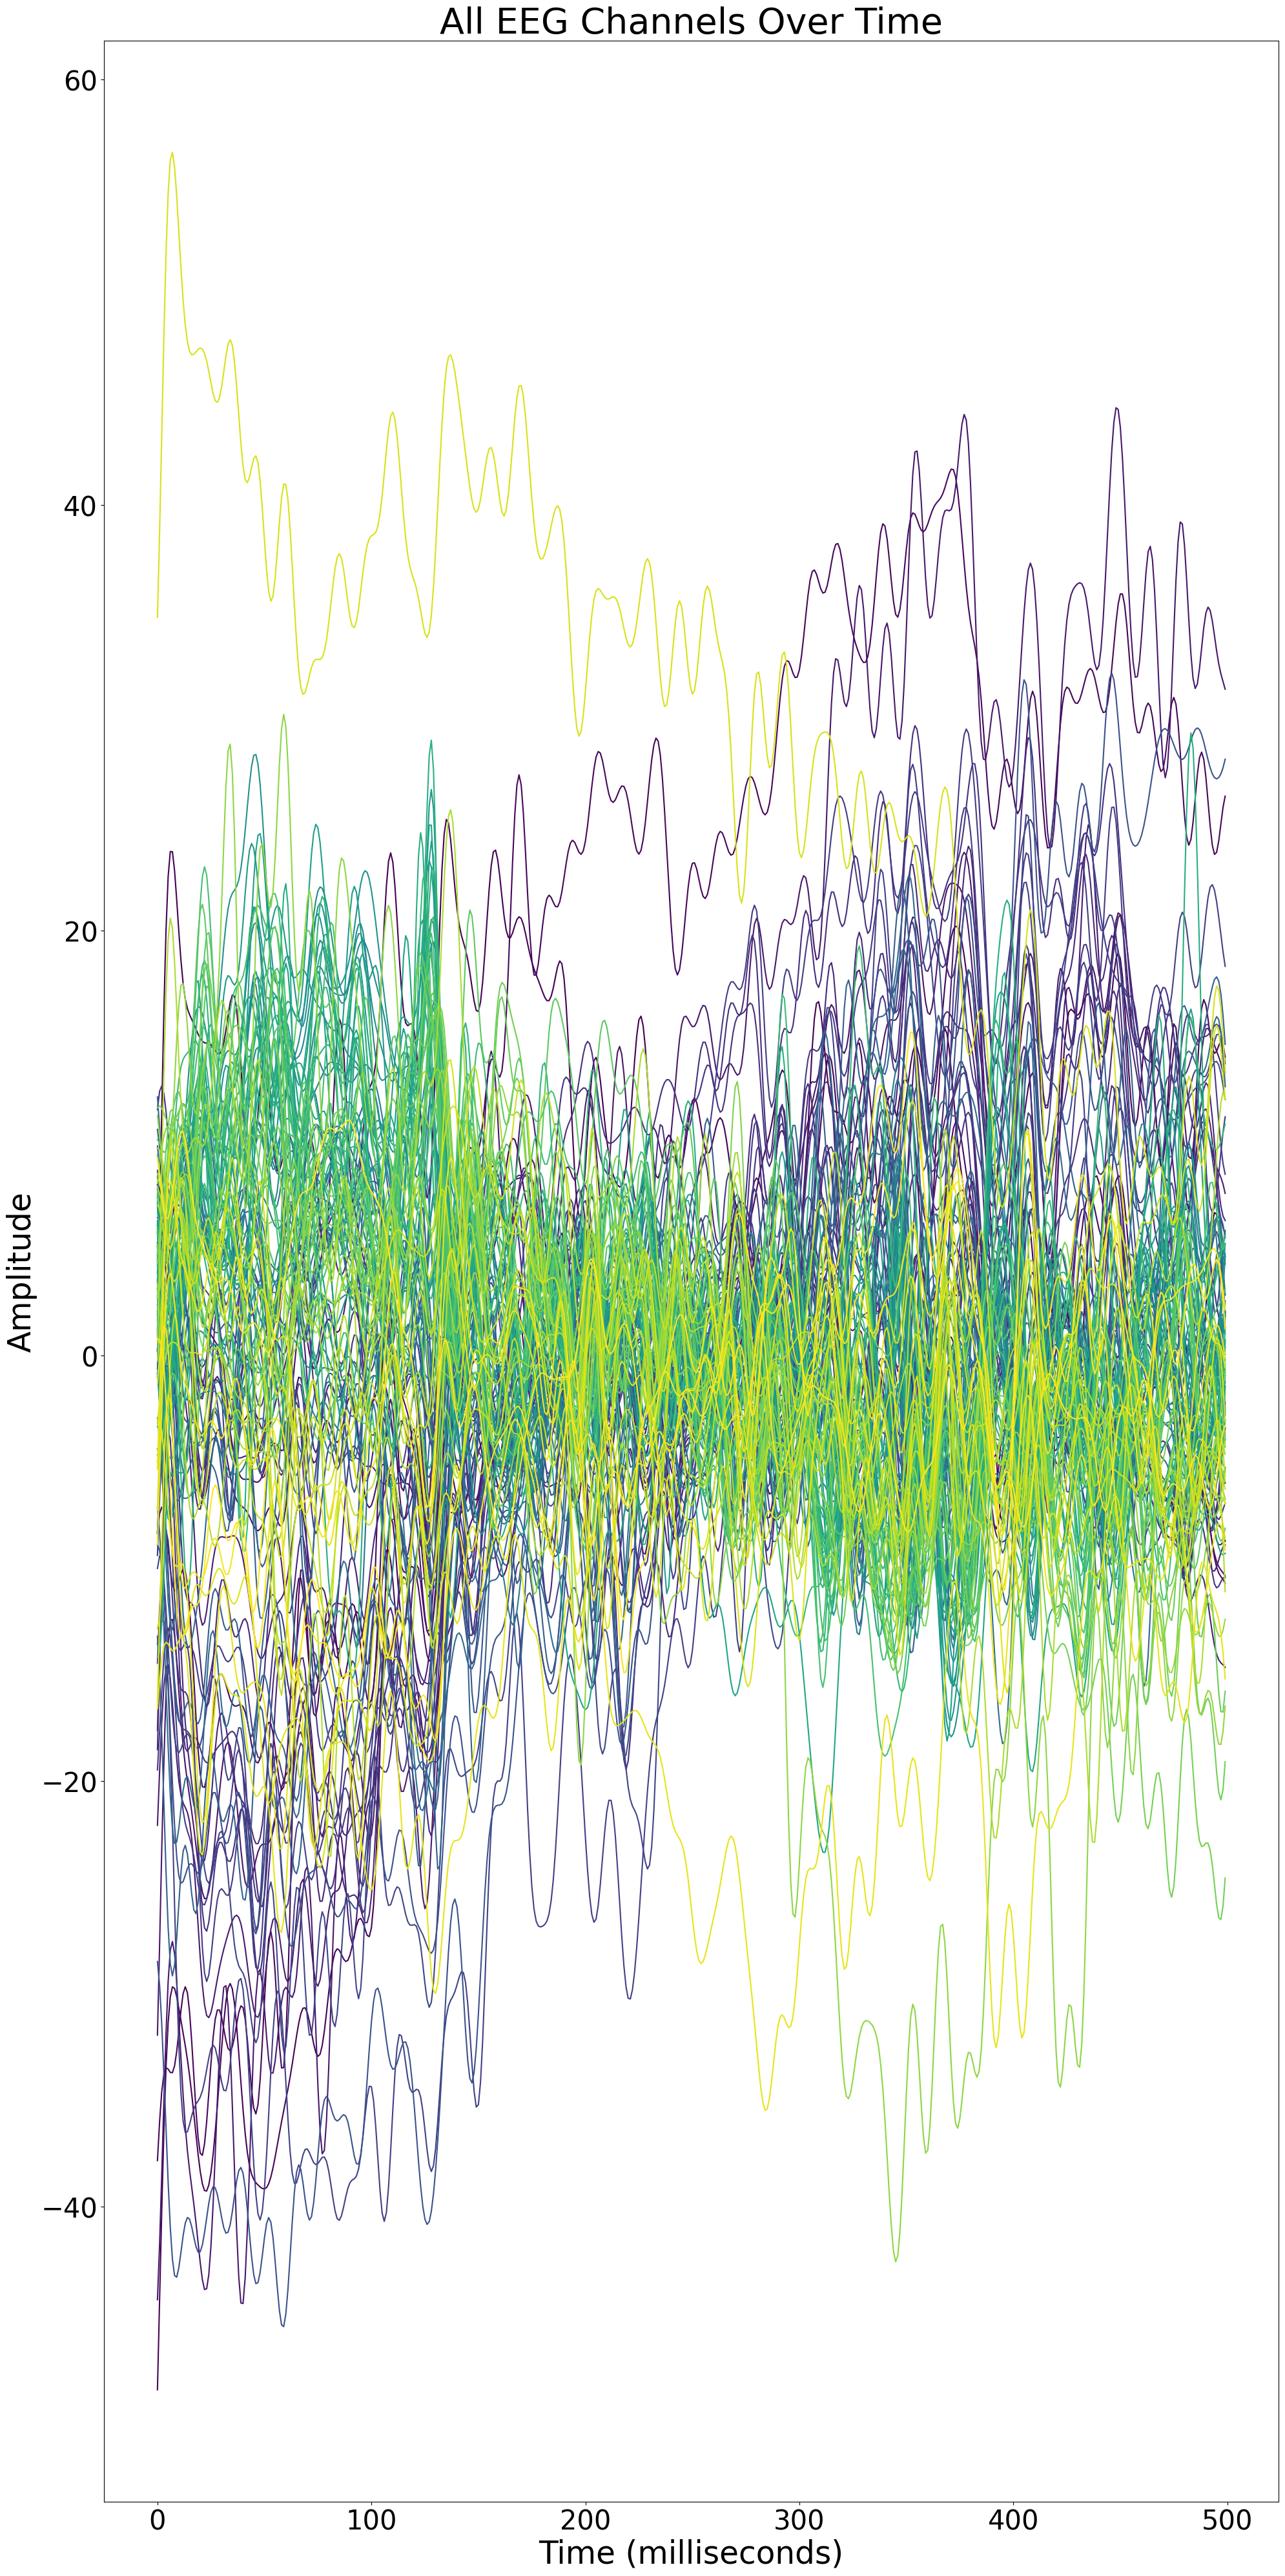

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Total number of channels
total_channels = 129

# Select all channels
channels_to_plot = np.arange(total_channels)  # Select all channels from 0 to 128

# Assuming each time step represents 1 millisecond for x-axis labeling
time_steps = EEGEyeNet.trainX.shape[-1]
time = np.arange(time_steps)  # Generate a time array

# Create a color map to use different colors for each channel
colors = plt.cm.viridis(np.linspace(0, 1, total_channels))

# Select a sample to visualize
sample_index = 0  # You can change this to view different samples

plt.figure(figsize=(20, 40))  # Large figure size to accommodate all channels

for i, channel in enumerate(channels_to_plot):
    plt.plot(time, EEGEyeNet.trainX[sample_index, 0, channel, :], color=colors[i])

plt.title('All EEG Channels Over Time', fontsize=40)  # Significantly increased font size for the title
plt.xlabel('Time (milliseconds)', fontsize=35)  # Increased font size for the x-axis label
plt.ylabel('Amplitude', fontsize=35)  # Increased font size for the y-axis label
plt.tick_params(axis='both', which='major', labelsize=30)  # Increase tick label size
plt.tight_layout()
plt.show()


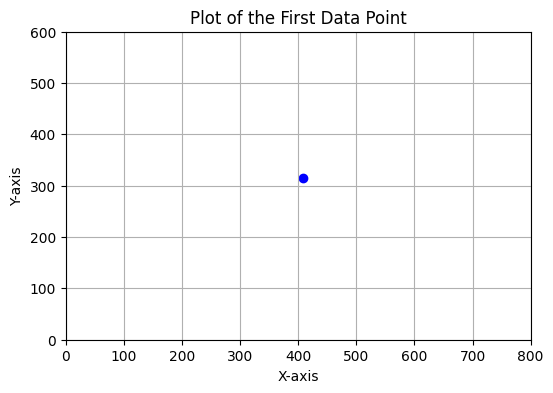

In [16]:
import matplotlib.pyplot as plt

# Assuming EEGEyeNet.trainY is a DataFrame that looks like the one you've shown.
# Extracting the values for the first index
x_value = EEGEyeNet.trainY.iloc[0, 0]
y_value = EEGEyeNet.trainY.iloc[0, 1]

# Creating the plot
plt.figure(figsize=(6, 4))
plt.scatter(x_value, y_value, color='blue')  # You can change the color if needed

plt.title("Plot of the First Data Point")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.xlim(0, 800)  # Setting the x-axis limits
plt.ylim(0, 600)  # Setting the y-axis limits
plt.grid(True)
plt.show()


In [9]:
EEGEyeNet.trainX.shape

(21464, 1, 129, 500)

In [22]:
EEGEyeNet.trainX[0].shape

(1, 129, 500)

##Visualize Data

In [11]:

if environment == Environment.COLAB:
  from google.colab import data_table
  data_table.enable_dataframe_formatter()
  from google.colab import autoviz


In [12]:
def scatter_plots(df, colname_pairs, figscale=2, alpha=.8):

  plt.figure(figsize=(12, 8))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    df.plot(kind='scatter', x=x_colname, y=y_colname, s=(2*figscale), alpha=alpha, ax=ax)
    ax.spines[['top', 'right',]].set_visible(False)
    ax.grid(True)
  plt.tight_layout()
  plt.xlim(0,800)
  plt.ylim(0,600)

  return autoviz.MplChart.from_current_mpl_state()

if environment == Environment.COLAB:
  chart = scatter_plots(EEGEyeNet.trainY, *[[[1, 2]]], **{})

  chart


#Preprocess data

#Make into Clustering Problem


In [13]:
if run_type in [RunType.CLUSTER]:

  df = EEGEyeNet.trainY

  df = df[(df >= 0).all(axis=1)]

  kmeans = KMeans(n_clusters=num_clusters, random_state = SEED)
  kmeans.fit(df.iloc[:,0:2])
  centroids = kmeans.cluster_centers_

  predictions = pd.DataFrame(kmeans.predict(df.iloc[:,0:2]), index = df.index)

  centers = pd.DataFrame(centroids[predictions.iloc[:,0]], index = predictions.index)

  EEGEyeNet.trainY = centers




/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


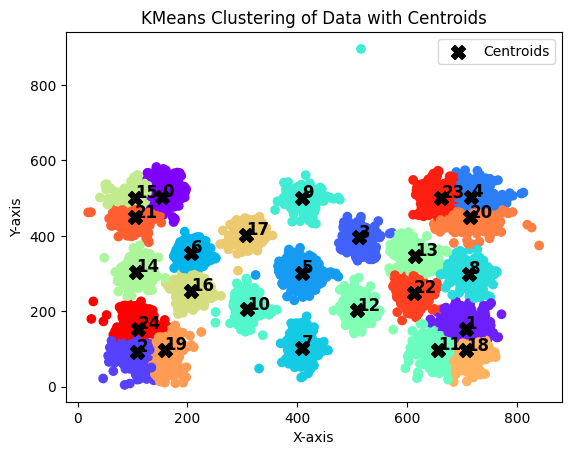

In [14]:
if run_type in [RunType.CLUSTER]:
  # Plotting the data points and centroids
  plt.scatter(df.iloc[:, 0], df.iloc[:, 1], c=predictions.iloc[:, 0], cmap='rainbow')
  plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', s=100, c='black', label='Centroids')

  # Annotating the centroids with predicted labels
  for i, centroid in enumerate(centroids):
      plt.annotate(str(i), (centroid[0], centroid[1]), fontsize=12, fontweight='bold')

  plt.title("KMeans Clustering of Data with Centroids")
  plt.xlabel("X-axis")
  plt.ylabel("Y-axis")
  plt.legend()
  plt.show()

<ipython-input-15-f6fd6476d8dc>:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(EEGEyeNet.trainY[0], EEGEyeNet.trainY[1], cmap='viridis', s=3)


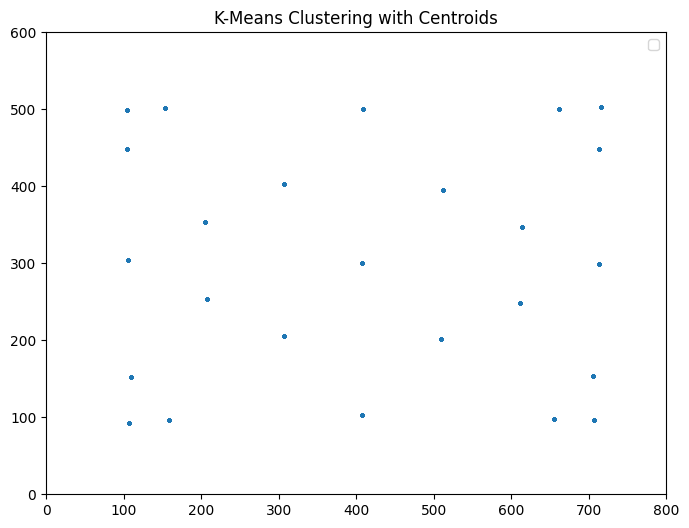

In [15]:
if run_type==RunType.CLUSTER:
  EEGEyeNet.trainY = EEGEyeNet.trainY.astype(int)

  plt.figure(figsize=(8, 6))  # Width x Height in inches

  plt.xlim(0,800)
  plt.ylim(0,600)
  plt.scatter(EEGEyeNet.trainY[0], EEGEyeNet.trainY[1], cmap='viridis', s=3)
  plt.legend()
  plt.title('K-Means Clustering with Centroids')
  plt.show()

#Make into Classification Problem

In [16]:
if run_type==RunType.CLASSIFIER:

  df = EEGEyeNet.trainY

  df = df[(df >= 0).all(axis=1)]

  kmeans = KMeans(n_clusters=num_clusters, random_state = SEED)
  kmeans.fit(df.iloc[:,0:2])
  centroids = kmeans.cluster_centers_

  predictions = pd.DataFrame(kmeans.predict(df.iloc[:,0:2]), index = df.index)

  centers = pd.DataFrame(centroids[predictions.iloc[:,0]], index = predictions.index)

  #center_points = df.apply(lambda row: predict_row(row), axis=1)

  # df_w_centroids = center_points.apply(lambda row: centroids[row[0]] )
  EEGEyeNet.trainY = predictions


In [17]:
if run_type in [RunType.CLASSIFIER]:
  plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', s=100, c='black', label='Centroids')

  # Annotating the centroids with predicted labels
  for i, centroid in enumerate(centroids):
      plt.annotate(str(i), (centroid[0], centroid[1]), fontsize=12, fontweight='bold')

  plt.title("KMeans Clustering of Data with Centroids")
  plt.xlabel("X-axis")
  plt.ylabel("Y-axis")
  plt.legend()
  plt.show()

#Train Model

In [18]:

match run_type:
  case RunType.CLASSIFIER:
    model = EEGViT_classifier( )
  case _:
    # model = EEGViT_pretrained(dropout, conv1_bias, channels1, channels2, m2, model_name, kernel1, kernel2)
    model=EEGViT_pretrained()



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- vit.embeddings.patch_embeddings.projection.weight: found shape torch.Size([768, 3, 16, 16]) in the checkpoint and torch.Size([768, 512, 8, 1]) in the model instantiated
- vit.embeddings.position_embeddings: found shape torch.Size([1, 197, 768]) in the checkpoint and torch.Size([1, 225, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_regularization)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.1)

Reference of the following cell: [EEGViT](https://github.com/ruiqiRichard/EEGViT)

## Begin Training

In [21]:
target_size = 4 if not run_type==RunType.CLUSTER else 8

def plot_coordinates_with_threshold(data, threshold):
    count =0
    plt.figure(figsize=(20, 14))

    for a,b,x,y, rmse in data:
        line_color = 'g' if rmse <= threshold else 'r'
        if rmse <= threshold:
            #count
            plt.plot(x, y,  'bo',markersize=4)
        else:
            plt.plot(x, y, 'rx', markersize=4 )
            count+=1

        # Plot a line between (a,b) and (x,y) with the specified color and opacity
        plt.plot([a, x], [b, y], line_color + '-', alpha=0.02)
        plt.plot(a, b,  'bo',markersize=target_size, alpha=0.05)

    plt.xlim(0,800)
    plt.ylim(0,600)
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.title("Coordinates Categorized by RMSE")
    # print(count)
    plt.show()

def custom_loss(mse):
    rmse = np.sqrt(mse)/2
    return rmse


def split(data):
    # Calculate the split points

    split1 = len(data)-3481-3277
    split2 = len(data)-3481

    # Split the data into three parts
    train = data[:split1]
    val = data[split1:split2]
    test = data[split2:]

    return train, val, test

def train(model, optimizer, scheduler=None, patience=3):
    '''
      model: model to train
      optimizer: optimizer to update weights
      scheduler: scheduling learning rate, used when finetuning pretrained models
    '''
    torch.cuda.empty_cache()

    train_indices, val_indices, test_indices = split(EEGEyeNet.trainY.index)

    print(f'train: {len(train_indices)}, val: {len(val_indices)} test: {len(test_indices)}')

    print('create dataloader...')
    train = Subset(EEGEyeNet,indices=train_indices)
    val = Subset(EEGEyeNet,indices=val_indices)
    test = Subset(EEGEyeNet,indices=test_indices)

    if use_augmentation:
      flipped_train = Subset(EEGEyeNet_Flipped,indices=train_indices)
      augmented_train = ConcatDataset([train, flipped_train])
      train_loader = DataLoader(augmented_train, batch_size=batch_size, shuffle=True)
    else:
      train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)

    val_loader = DataLoader(val, batch_size=batch_size)
    test_loader = DataLoader(test, batch_size=1)

    if torch.cuda.is_available():
      gpu_id = 0  # Change this to the desired GPU ID if you have multiple GPUs
      torch.cuda.set_device(gpu_id)
      device = torch.device(f"cuda:{gpu_id}")
    else:
      device = torch.device("cpu")

    if torch.cuda.device_count() > 1:
      model = nn.DataParallel(model)  # Wrap the model with DataParallel

    model = model.to(device)

    match run_type:
      case RunType.CLASSIFIER:
        criterion = nn.CrossEntropyLoss()
      case _:
        criterion = nn.MSELoss()

    criterion = criterion.to(device)

    # Initialize lists to store losses
    train_losses = []
    val_losses = []
    test_losses = []

    print('training...')
    # Train the model


    for epoch in range(n_epoch):
      model.train()
      epoch_train_loss = 0.0

      true_labels = []
      predicted_labels = []
      output_and_rmse = []
      i=0

      # print(tqdm(enumerate(train_loader)))
      for value in train_loader:

        inputs, targets, index = value
        if run_type == RunType.CLASSIFIER:
          targets = targets.long()

        # Move the inputs and targets to the GPU (if available)
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Compute the outputs and loss for the current batch
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs.squeeze(), targets.squeeze())

        # Compute the gradients and update the parameters
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

        # Print the loss and accuracy for the current batch
        if i % 100 == 0:
            print(f"Epoch {epoch}, batch {i} train Loss: {custom_loss(loss.item())}")

        i+=1

      epoch_train_loss /= len(train_loader)
      train_losses.append(epoch_train_loss)

      # Evaluate the model on the validation set
      model.eval()
      if len(val_indices)>0:
        with torch.no_grad():
          val_loss = 0.0
          for inputs, targets, index in val_loader:
            # Move the inputs and targets to the GPU (if available)
            if run_type == RunType.CLASSIFIER:
              targets = targets.long()

            inputs = inputs.to(device)
            targets = targets.to(device)
            # Compute the outputs and loss for the current batch
            outputs = model(inputs)
            # print(outputs)
            loss = criterion(outputs.squeeze(), targets.squeeze())
            val_loss += loss.item()

          val_loss /= len(val_loader)
          val_losses.append(val_loss)

          # Early stopping logic
          if val_loss == min(val_losses):
              best_val_loss = min(val_losses)
              torch.save(model.state_dict(), f'{file_dir}{save_model_as}')
              epochs_no_improve = 0
          else:
              epochs_no_improve += 1

      if len(test_indices)>0:
        with torch.no_grad():
          val_loss = 0.0

          for inputs, targets, index in test_loader:
            # Move the inputs and targets to the GPU (if available)

            if run_type == RunType.CLASSIFIER:
              targets = targets.long()

            inputs = inputs.to(device)
            targets = targets.to(device)
            # Compute the outputs and loss for the current batch
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets.squeeze())
            val_loss += loss.item()

            #classifier
            if run_type == RunType.CLASSIFIER:
              _, preds = torch.max(outputs, 1)
              true_labels.extend(targets.cpu().numpy())
              predicted_labels.extend(preds.cpu().numpy())

            if  run_type in [RunType.NORMAL, RunType.CLUSTER]:
              x,y = outputs.tolist()[0]
              a,b = targets.tolist()[0]

              output_and_rmse.append([a,b,x,y, sqrt(loss.item())])

          if scheduler is not None:
            scheduler.step()
          print(f"Epoch {epoch}, Best Val Loss: {min(custom_loss(val_losses))}")

          pyplot.plot(custom_loss(train_losses), label = "Training Loss")
          pyplot.plot(custom_loss(val_losses), label= "Validation Loss")
          pyplot.legend()
          pyplot.show()

          if  run_type in [RunType.NORMAL, RunType.CLUSTER]:
            plot_coordinates_with_threshold(output_and_rmse, plot_threshold)


        if epochs_no_improve == patience:
          print(f"No improvement in validation loss for {patience} epochs, stopping training.")
          break

    # Load best model
    model.load_state_dict(torch.load(f'{file_dir}{save_model_as}'))

    # Evaluation on the test set only in the last epoch or if early stopping was triggered
    if len(test_indices) > 0:
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for inputs, targets, index in test_loader:
                if run_type == RunType.CLASSIFIER:
                    targets = targets.long()
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), targets.squeeze())
                test_loss += loss.item()

        test_loss /= len(test_loader)
        print(f"Final Test Loss: {custom_loss(test_loss)}")

In [ ]:
train(model,optimizer=optimizer, scheduler=scheduler)

## Stop Runtime
stop runtime so it doesnt charge for more time

In [ ]:
#stop runtime
from google.colab import runtime
runtime.unassign()